# Example of processing moment magnitudes for an entire earthqauke catalogue

This example shows how to use SeisSrcMoment to process an entire earthquake catalogue.

Notes for this example:

We do not include all the data to run for an entire earthquake catalogue, as that would be inappropriate to host on GitHub. However, instead we:
1. Include an example event to show how a full catalogue would be processed.
2. Include a python dictionary that is in the same format as the outputs from SeisSrcMoment, for a full earthquake catalogue from Uturuncu volcano, Bolivia, in order to show how the catalogue post-processing code works.
3. Shows example of how to analyse and plot temporal b-value variations.

In [1]:
# Import neccessary modules:
import SeisSrcMoment
import pandas as pd
%load_ext autoreload
%autoreload 2

## 1. Find magnitudes for small catalogue example:

In [2]:
# Specify parameters for processing catalogue:
inventory_fname = "data/IRISDMC-Plutons_dataless.dataless"  # The inventory fname, pointing to the dataless file for the network
mseed_dir = "data/mseed_data"
out_fname = 'small_vt_magnitudes_catalogue.pkl'
nonlinloc_hyp_files_dir = "data/NLLoc_data"
nonlinloc_hyp_files_list = ['loc.Tom_RunNLLoc000.20100516.063457.grid0.loc.hyp']
stations_not_to_process = []
window_before_after = [0.1, 0.6] # The time before and after the phase pick to use for calculating the magnitude within (in seconds)
filt_freqs = [0.5, 49.0] # The frequencies with which to filter the data prior to calculating the moment magnitude.
MT_six_tensor = [] # If not specified, assumes isotropic source.
density = 2750. # Density of medium, in kg/m3
Vp = 'from_depth' # P-wave velocity in m/s (or str if using from depth. If from_depth, will use vel_model_df to determine velocity model)
phase_to_process = 'P' # P or S. Phase to process. If P, will use L component, if S will use T component.
vel_model_df = pd.read_csv("data/1D_vel_model.csv") # Velocity model to use if Vp = 'from_depth'
verbosity_level = 1 # Verbosity level (1 for moment only) (2 for major parameters) (3 for plotting of traces)
plot_switch = False
remove_noise_spectrum = False # If True, removes noise using spectrum taken from window before trace.


In [3]:
# Process data for small catalogue (single event in this case):
small_mags_dict = SeisSrcMoment.catalogue.get_event_moment_magnitudes(nonlinloc_hyp_files_dir, nonlinloc_hyp_files_list, mseed_dir, out_fname, window_before_after, filt_freqs, density, Vp, phase_to_process=phase_to_process, MT_six_tensor=MT_six_tensor, stations_not_to_process=stations_not_to_process, inventory_fname=inventory_fname, remove_noise_spectrum=remove_noise_spectrum, vel_model_df=vel_model_df, verbosity_level=verbosity_level, plot_switch=plot_switch)


-----------------------------------------------------
Processing for event: data/NLLoc_data/loc.Tom_RunNLLoc000.20100516.063457.grid0.loc.hyp
 Using average radiation pattern value instead.


/Users/eart0504/opt/anaconda3/lib/python3.7/site-packages/obspy/io/xseed/fields.py:377: UserWarning: Date is required.
  warnings.warn('Date is required.', UserWarning)


Station (PLLO) or channel (HHN) not in instrument inventory, therefore not correcting for this component and removing it.
Station (PLLO) or channel (HHZ) not in instrument inventory, therefore not correcting for this component and removing it.
Station (PLLO) or channel (HHE) not in instrument inventory, therefore not correcting for this component and removing it.
Processing data for station: PLLO
Processing data for station: PLSM
Overall seismic moment (Nm): 1.55215664672e+13
Processing data for station: PLLA
Overall seismic moment (Nm): 1.38018552342e+13
Processing data for station: PLTM
Overall seismic moment (Nm): 2.55737732578e+13
Processing data for station: PLRR
Overall seismic moment (Nm): 1.95712987882e+13
Processing data for station: PLAR
Overall seismic moment (Nm): 5.47155095074e+12
Processing data for station: PL03
Overall seismic moment (Nm): 4.87279462162e+13
Average seismic moment for event: 2.14446651524e+13 +/- 5.5617055729e+12
Moment magnitude and error: 2.88754617956

In [4]:
# And print example of output dict structure:
small_mags_dict

{'data/NLLoc_data/loc.Tom_RunNLLoc000.20100516.063457.grid0.loc.hyp': {'PLSM': {'M_0': 15521566467248.895,
   'Sigma_0': 7.4623548828840144e-08,
   'f_c': 9.888233395707239,
   't_star': 0.03633999901647883,
   'Q': 99.043608076584192,
   'Sigma_0_stdev': 9.0878597766005378e-09,
   'f_c_stdev': 8.7428868107411581,
   't_star_stdev': 0.030655754236235826,
   'Q_stdev': 117.40845103191727},
  'PLLA': {'M_0': 13801855234245.539,
   'Sigma_0': 8.9939748065881305e-08,
   'f_c': 6.3043116845446159,
   't_star': 0.033927714082159638,
   'Q': 109.11501441222499,
   'Sigma_0_stdev': 8.2211626469365906e-09,
   'f_c_stdev': 3.6489702498794476,
   't_star_stdev': 0.030949005246824712,
   'Q_stdev': 119.61686592264596},
  'PLTM': {'M_0': 25573773257795.145,
   'Sigma_0': 9.8753725193447377e-08,
   'f_c': 9.5176292426311448,
   't_star': 0.030846363104357177,
   'Q': 136.32753906249513,
   'Sigma_0_stdev': 1.0967411233746552e-08,
   'f_c_stdev': 7.559368629234954,
   't_star_stdev': 0.02841449572891

Note that one not only gets the seismic moment release, M_0 for each event (which can easily be converted into $M_w$), but also:
1. $t^*$, which can be used for attenuation tomography.
2. An approximation of the path-average Q, which can be used to assess the potential for attenuation tomography.
3. $f_c$, the corner frequency, which can be used for stress-drop or earthquake fault area calculations.

## 2. Plot up entire large VT catalogue as Gutenberg-Richter distribution:

Note that the code supports a number of ways to find the magnitude of completeness, Mc. The one we use here is the b-value stability method (BVS), detailed in Roberts et al 2015.

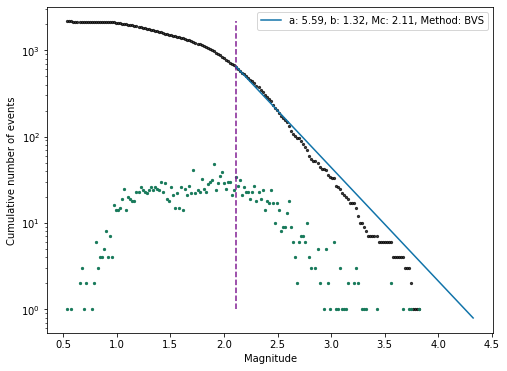

In [5]:
entire_large_mags_catalogue_fname = "data/catalogue_output_data/entire_vt_magnitudes_catalogue.pkl"
SeisSrcMoment.catalogue.plot_summary_Gutenberg_Richter(entire_large_mags_catalogue_fname, Q_filt=1000., upper_Mw_filt=4.0, Mc_method="BVS", fig_out_fname='')


## 3. Analyse and plot b-value temporal variaitons:

In [6]:
# Notes:
# Uses Roberts et al 2016 method

# Specify parameters for plotting b-value temporal variations:

# Note:
# Uses Smith1981 methog to find b-value (Aki maximum likelihood method)
# Set specific b-value through time parameters:
M_completeness = 2.11
eq_samp_size = 100 #100 # The window size for the moving calculation of b-value

# Get earthquake magnitudes dict:
entire_large_mags_catalogue_dict = SeisSrcMoment.catalogue.read_magnitude_catalogue(entire_large_mags_catalogue_fname)

# Set parameters:
Q_filt = 1000.
upper_Mw_filt = 4.0
min_max_mag_plot_lims = [-1.0, 4.5]
fig_out_fname = ''

# Sort nonlinloc event fnames into ascending order:
nonlinloc_fnames = list(entire_large_mags_catalogue_dict.keys())
nonlinloc_fnames_time_sorted = SeisSrcMoment.catalogue.sort_nonlinloc_fnames_into_chrono_order(nonlinloc_fnames)


In [14]:
# Calculate b-values through time, entire region:
event_times, b_values_through_time, b_values_errs_through_time = SeisSrcMoment.catalogue.calc_b_values_through_time_probabilistic(nonlinloc_fnames_time_sorted, entire_large_mags_catalogue_dict,
                                                                    min_eq_samp_size=50, max_eq_samp_size=500, number_of_eq_samp_windows=5000, 
                                                                        Q_filt=Q_filt, upper_Mw_filt=upper_Mw_filt)

Processing for eq samp window: 0 / 5000
Processing for eq samp window: 1000 / 5000
Processing for eq samp window: 2000 / 5000
Processing for eq samp window: 3000 / 5000
Processing for eq samp window: 4000 / 5000


In [15]:
# And calc. event window pdfs:
time_labels, b_value_labels, b_value_time_array, b_values_through_time_pdfs = SeisSrcMoment.catalogue.calc_event_window_pdf(event_times, b_values_through_time, b_values_errs_through_time, num_samps_per_window=10, b_value_res=0.01)


/Users/eart0504/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


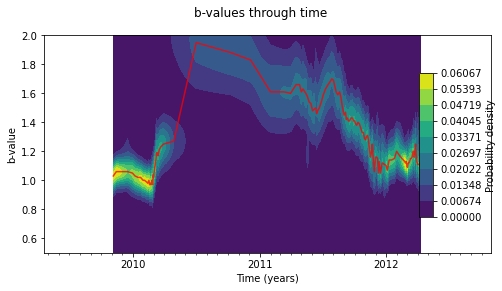

In [16]:
# And plot b-values throguh time:
fig = SeisSrcMoment.catalogue.plot_temporal_b_values(time_labels, b_value_labels, b_value_time_array)
fig.show()
